In [2]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

In [3]:
base_path = "data"
words_list = []

words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":  # errored entries
        words_list.append(line)

len(words_list)

np.random.shuffle(words_list)

In [4]:
split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(
    test_samples
)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total training samples: 86810
Total validation samples: 4823
Total test samples: 4823


In [5]:
base_image_path = os.path.join(base_path, "words")


def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

        # Each line split will have this format for the corresponding image:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

In [6]:
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some label samples.
train_labels_cleaned[:10]

Maximum length:  21
Vocab size:  78


['sure',
 'he',
 'during',
 'of',
 'booty',
 'gastronomy',
 'boy',
 'The',
 'and',
 'in']

In [7]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

In [9]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Amount of padding needed
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

In [10]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

In [11]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

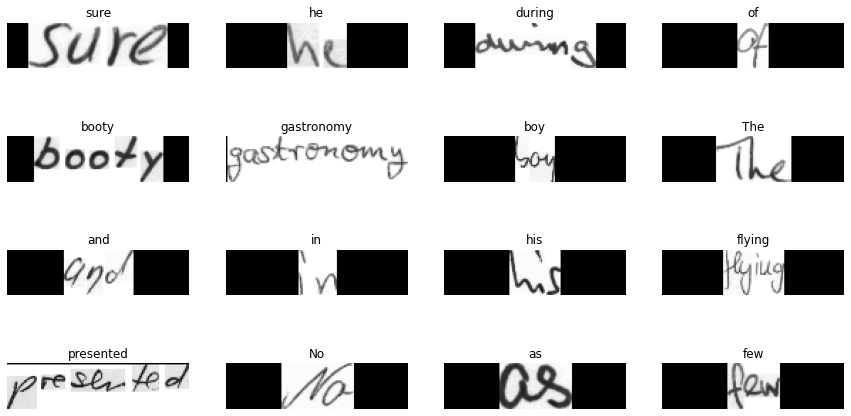

In [13]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))

        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()

In [14]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred


def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)


    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    output = CTCLayer(name="ctc_loss")(labels, x)

    # Definning the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    
    # Optimising
    opt = keras.optimizers.Adam()
    
    # Compile the model
    model.compile(optimizer=opt)
    return model


# Get the model.
model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 64, 16, 32)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 64, 16, 64)   18496       ['pool1[0][0

In [15]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

In [16]:
def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )

In [21]:
epochs = 10 #could be more for a better model

model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback],
)

Epoch 1/10
1357/1357 [==============================] - 218s 158ms/step - loss: 13.4607 - val_loss: 11.4758
Epoch 2/10
1357/1357 [==============================] - 177s 130ms/step - loss: 10.2903 - val_loss: 8.9851
Epoch 3/10
1357/1357 [==============================] - 178s 131ms/step - loss: 8.1697 - val_loss: 6.6827
Epoch 4/10
1357/1357 [==============================] - 180s 133ms/step - loss: 6.3551 - val_loss: 5.0120
Epoch 5/10
1357/1357 [==============================] - 184s 135ms/step - loss: 5.2160 - val_loss: 4.1566
Epoch 6/10
1357/1357 [==============================] - 186s 137ms/step - loss: 4.5080 - val_loss: 3.5826
Epoch 7/10
1357/1357 [==============================] - 184s 136ms/step - loss: 4.0324 - val_loss: 3.2261
Epoch 8/10
1357/1357 [==============================] - 180s 133ms/step - loss: 3.7130 - val_loss: 3.0936
Epoch 9/10
1357/1357 [==============================] - 180s 133ms/step - loss: 3.4567 - val_loss: 2.9152
Epoch 10/10
1357/1357 [====================

In [22]:
prediction_model

In [19]:
model

In [23]:
prediction_model.save('handWrittenWordsModelToday')
prediciton_model.save('handWrittenWordsModelToday.h5')

INFO:tensorflow:Assets written to: handWrittenWordsModelToday\assets


INFO:tensorflow:Assets written to: handWrittenWordsModelToday\assets


NameError: name 'prediciton_model' is not defined

In [25]:
 new_model = keras.models.load_model('handWrittenWordsModelToday', compile=False)

In [26]:
new_model

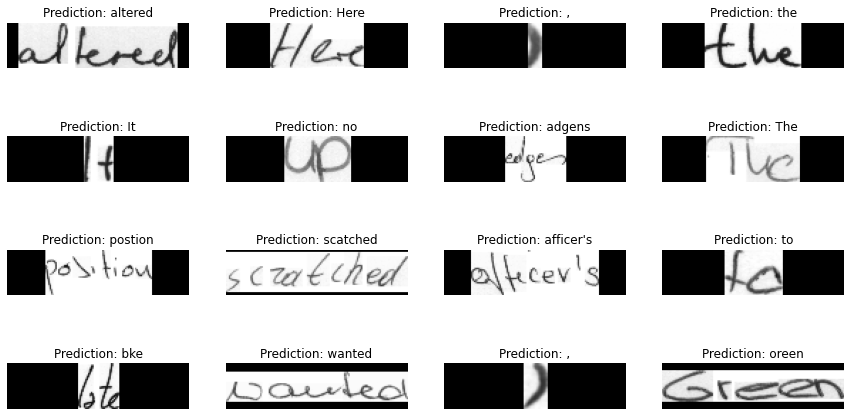

In [51]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

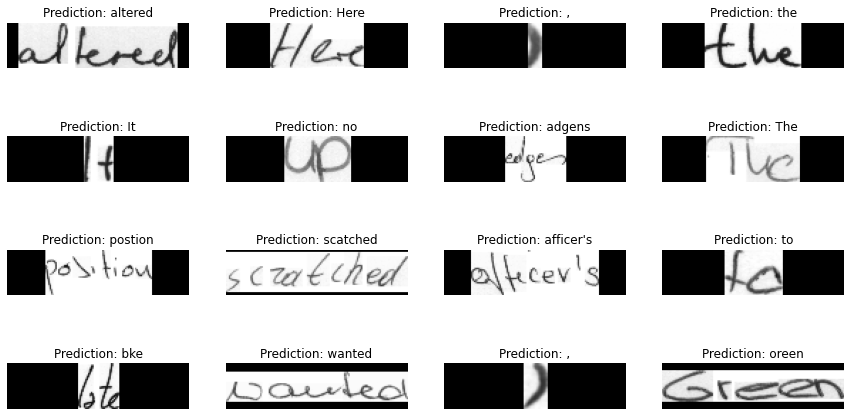

In [27]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = new_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

In [49]:
def runModel(fileName):
    sample_ds = prepare_dataset([fileName], ['sure'])

    for batch in sample_ds.take(1):
        batch_images = batch["image"]
        # _, ax = plt.subplots(4, 4, figsize=(15, 8))

        preds = prediction_model.predict(batch_images)
        pred_texts = decode_batch_predictions(preds)

        print(pred_texts)

        return pred_texts[0]

In [50]:
from flask import Flask, flash, request, redirect, url_for, render_template
from werkzeug.wrappers import Request, Response
import urllib.request
import os
from werkzeug.utils import secure_filename

app = Flask(__name__)

UPLOAD_FOLDER = 'static/uploads/'

app.secret_key = "secret key"
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER
app.config['MAX_CONTENT_LENGTH'] = 16 * 1024 * 1024

ALLOWED_EXTENSIONS = set(['png', 'jpg', 'jpeg', 'gif'])


def allowed_file(filename):
    return '.' in filename and filename.rsplit('.', 1)[1].lower() in ALLOWED_EXTENSIONS


@app.route('/')
def home():
    return render_template('index.html')
    # return "<h1>Hello world</h1>"


@app.route('/', methods=['POST'])
def upload_image():
    if 'file' not in request.files:
        flash('No file part')
        return redirect(request.url)
    file = request.files['file']
    if file.filename == '':
        flash('No image selected for uploading')
        return redirect(request.url)
    if file and allowed_file(file.filename):
        filename = secure_filename(file.filename)
        file.save(os.path.join(app.config['UPLOAD_FOLDER'], filename))
        print('upload_image filename: ' + filename)

        result = runModel('static\\uploads\\' + str(filename))
        flash(str(result))
        return render_template('index.html', filename=filename)
    else:
        flash('Allowed image types are - png, jpg, jpeg, gif')
        return redirect(request.url)


@app.route('/display/<filename>')
def display_image(filename):
    #print('display_image filename: ' + filename)
    return redirect(url_for('static', filename='uploads/' + filename), code=301)


if __name__ == "__main__":
    from werkzeug.serving import run_simple
    run_simple('localhost', 10000, app)


INFO:werkzeug: * Running on http://localhost:10000/ (Press CTRL+C to quit)
INFO:werkzeug:127.0.0.1 - - [11/Jun/2022 12:12:34] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jun/2022 12:12:38] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jun/2022 12:12:38] "GET /display/a02-004-00-00.png HTTP/1.1" 301 -


upload_image filename: a02-004-00-00.png
['so']


INFO:werkzeug:127.0.0.1 - - [11/Jun/2022 12:12:39] "GET /static/uploads/a02-004-00-00.png HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jun/2022 12:12:46] "POST / HTTP/1.1" 200 -


upload_image filename: a02-004-00-02.png
['ioden']


INFO:werkzeug:127.0.0.1 - - [11/Jun/2022 12:12:46] "GET /display/a02-004-00-02.png HTTP/1.1" 301 -
INFO:werkzeug:127.0.0.1 - - [11/Jun/2022 12:12:46] "GET /static/uploads/a02-004-00-02.png HTTP/1.1" 200 -


upload_image filename: a02-004-00-03.png


INFO:werkzeug:127.0.0.1 - - [11/Jun/2022 12:14:18] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jun/2022 12:14:18] "GET /display/a02-004-00-03.png HTTP/1.1" 301 -
INFO:werkzeug:127.0.0.1 - - [11/Jun/2022 12:14:18] "GET /static/uploads/a02-004-00-03.png HTTP/1.1" 200 -


['of']
upload_image filename: a02-004-00-01.png


INFO:werkzeug:127.0.0.1 - - [11/Jun/2022 12:14:23] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jun/2022 12:14:23] "GET /display/a02-004-00-01.png HTTP/1.1" 301 -
INFO:werkzeug:127.0.0.1 - - [11/Jun/2022 12:14:23] "GET /static/uploads/a02-004-00-01.png HTTP/1.1" 200 -


['the']


INFO:werkzeug:127.0.0.1 - - [11/Jun/2022 12:36:28] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jun/2022 12:36:28] "GET /display/a02-004-05-03.png HTTP/1.1" 301 -


upload_image filename: a02-004-05-03.png
['back']


INFO:werkzeug:127.0.0.1 - - [11/Jun/2022 12:36:29] "GET /static/uploads/a02-004-05-03.png HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jun/2022 12:45:21] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jun/2022 12:45:21] "GET /display/a02-004-01-01.png HTTP/1.1" 301 -


upload_image filename: a02-004-01-01.png
['Pnime']


INFO:werkzeug:127.0.0.1 - - [11/Jun/2022 12:45:22] "GET /static/uploads/a02-004-01-01.png HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jun/2022 13:57:22] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jun/2022 13:57:22] "GET /static/uploads/a02-004-00-03.png HTTP/1.1" 200 -


upload_image filename: a02-004-00-03.png
['of']


INFO:werkzeug:127.0.0.1 - - [11/Jun/2022 14:02:50] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jun/2022 14:02:50] "GET /static/uploads/a02-004-00-01.png HTTP/1.1" 200 -


upload_image filename: a02-004-00-01.png
['the']
upload_image filename: a02-004-00-00.png
['so']


INFO:werkzeug:127.0.0.1 - - [11/Jun/2022 14:03:02] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jun/2022 14:03:02] "GET /static/uploads/a02-004-00-00.png HTTP/1.1" 200 -


upload_image filename: a02-004-01-00.png
['the']


INFO:werkzeug:127.0.0.1 - - [11/Jun/2022 14:03:33] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jun/2022 14:03:33] "GET /display/a02-004-01-00.png HTTP/1.1" 301 -
INFO:werkzeug:127.0.0.1 - - [11/Jun/2022 14:03:33] "GET /static/uploads/a02-004-01-00.png HTTP/1.1" 200 -


upload_image filename: a02-004-01-01.png


INFO:werkzeug:127.0.0.1 - - [11/Jun/2022 14:04:01] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [11/Jun/2022 14:04:01] "GET /static/uploads/a02-004-01-01.png HTTP/1.1" 200 -


['Pnime']
